# Neural decoding: multiple environments

Here is a full example of using the tools in the `fklab.decode` module to perform spike-sorting-less decoding of a subject's position in multiple environments (i.e. 2 maze arms) from spiking activity recorded on multiple tetrodes. To check decoding performance, we perform cross-validation in which each trial is used in turn to test the encoding model that is built from the other trials.

In [ ]:
# import numerical libraries
import numpy as np
import scipy.interpolate

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import fklab.utilities.yaml as yaml

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# finally, import the decoding tools
import fklab.decode

## retrieve data

In [ ]:
import pathlib

root_path = pathlib.Path("~/notebook_data_cache").expanduser()
path = root_path.joinpath("decoding")

if not path.exists():
    path.mkdir(parents=True)

datafile = path.joinpath("processed_data.hdf5")

if not datafile.exists():
    from fklab.io.cloud import dropboxAPI

    dbx = dropboxAPI.from_token(
        os.environ.get("BITBUCKET_TOKEN")
    )  # Replace by your own token
    dbx.download("/Data/decoding/processed_data.hdf5", datafile)

## define parameters
Here we set parameters for data processing and decoding.

In [ ]:
# define trial epochs
trials = fklab.segments.Segment(
    [[2100, 2250], [2250, 2355], [2355, 2455], [2455, 2550], [2550, 2650]]
)
ntrials = len(trials)

# select spike data
tt_selection = [
    "TT1",
    "TT15",
    "TT16",
    "TT17",
    "TT19",
    "TT20",
    "TT23",
    "TT24",
    "TT5",
]  # tetrodes to be used for decoding
amp_threshold = (
    70.0  # uV, only use spikes with maximum amplitude larger than this threshold
)

# set kernel bandwidths and compression for encoding
pos_bw = 5.0  # cm, default spatial kernel bandwidth
amp_bw = 30.0  # uV, default spike amplitude kernel bandwidth
compression = 1.0  # kernel density compression Mahalanobis distance threshold

# set evaluation grid resolution
grid_resolution = 4.0
# cm, spatial grid for decoding

# set behavior options
stim_sampling_frequency = 25.0  # Hz, sampling frequency of position tracking
speed_threshold = 10.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

# set decoding options
decode_bin = 0.1  # seconds, bin size for run decoding

## maze definition and evaluation grid
Here we define the maze. The maze consists of a stem and two target arms. For the current example, we are only interested in decoding position on the two target arms, which we will treat as separate environments.

In [ ]:
# define maze
# the maze consists of two arms (A and B)
# for each arm we define a region that encompasses the arm and a track for linearization
maze = "maze:\n  comments: ''\n  shapes:\n    A:\n      tags: [field]\n      comments: ''\n      shape: !rectangle_shape\n        center: [144.15177472789134, 197.98411427032022]\n        size: [38.17212048619184, 100.13608297421464]\n        orientation: 3.9344703966753123\n    B:\n      tags: [field]\n      comments: ''\n      shape: !rectangle_shape\n        center: [162.05016441089202, 79.24112784108591]\n        size: [30.75114800211974, 105.06051535288881]\n        orientation: 2.8785979219088738\n    Atrack:\n      tags: [track]\n      comments: ''\n      shape: !polyline_shape\n        vertices:\n        - [175.0, 165.0]\n        - [108.0, 228.0]\n        spline: false\n    Btrack:\n      tags: [track]\n      comments: ''\n      shape: !polyline_shape\n        vertices:\n        - [174.0, 127.0]\n        - [149.0, 31.0]\n        spline: false\n"
maze = yaml.load(maze, Loader=yaml.FullLoader)

# create dict with for each maze arm the shapes that describe the region
# around the arm and the track
arms = {
    k: {"region": v["shape"], "track": maze["maze"]["shapes"][k + "track"]["shape"]}
    for k, v in maze["maze"]["shapes"].items()
    if "field" in v["tags"]
}

<ipython-input-4-98b02c6a38f6>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  maze = yaml.load(maze)


## preprocess behavioral and spiking data
Here we load the data and select the behavioral samples when the subject is running on the maze arms A or B in each of the trials. We further select the corresponding spikes that have a minimum amplitude.

In [ ]:
# load behavioral and ephys data
f = h5py.File(datafile, "r")
behavior = f["training/behavior"]

# construct dict with for each maze arm a boolean vector that
# selects stimulus samples that are within maze arm region
# and when speed is high
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run = {
        k: np.logical_and(
            behavior["speed"][:] > speed_threshold,
            arm["region"].contains(behavior["positionsXY"][:]),
        )
        for k, arm in arms.items()
    }

# construct dict with for each maze arm the time epochs when the rat
# is running in that arm
seg = {
    k: fklab.segments.Segment.fromlogical(v, behavior["time"][:])
    for k, v in run.items()
}

# list with for each trial a boolean vector that selects the stimulus
# samples that were observed in that trial
stim_trials = [
    trials[trial].contains(behavior["time"][:])[0] for trial in range(ntrials)
]

In [ ]:
# tt_data is a dict with for each tetrode a (5,n) array with spike times
# and spike amplitudes
tt_data = f["training/ephys/MUA/tetrodes"]

# for each selected tetrodes, extract the times and amplitudes for all
# spikes with maximum amplitude larger than threshold
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    selection = [
        np.max(tt_data[tt][1:, :], axis=0) > amp_threshold for tt in tt_selection
    ]
tt_time = [tt_data[tt][:][0, sel] for tt, sel in zip(tt_selection, selection)]
tt_amp = [tt_data[tt][:][1:, sel].T for tt, sel in zip(tt_selection, selection)]

# interpolate position and speed
# fist construct interpolators
xy_interpolator = scipy.interpolate.interp1d(
    behavior["time"],
    behavior["positionsXY"][:],
    kind="nearest",
    axis=0,
    bounds_error=False,
)
speed_interpolator = scipy.interpolate.interp1d(
    behavior["time"], behavior["speed"][:], kind="nearest", bounds_error=False
)
# then perform interpolation for each selected tetrode
tt_xy = [xy_interpolator(x) for x in tt_time]
tt_speed = [speed_interpolator(x) for x in tt_time]

# construct dict with for each maze arm a list of boolean vectors that
# select the spikes on the selected tetrodes that were emitted when the
# animal ran at high speed in that arm
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    tt_run = {
        k: [
            np.logical_and(arm["region"].contains(xy), speed > speed_threshold)
            for xy, speed in zip(tt_xy, tt_speed)
        ]
        for k, arm in arms.items()
    }

# list with for each selected tetrode a list of boolean vectors that
# selects for each trial the spikes that occurred within that trial
tt_trials = [
    [trials[trial].contains(t)[0] for trial in range(ntrials)] for t in tt_time
]

# construct dict with for each maze arm a nested list that for each
# selected tetrode and trial contains a boolean vector that selects the
# spikes that were emitted when the animal ran at high speed in the maze
# arm within a given trial
tt_spike_selection = {
    k: [
        [np.logical_and(x, y[kk]) for kk in range(ntrials)]
        for x, y in zip(v, tt_trials)
    ]
    for k, v in tt_run.items()
}

## define decoding spaces and grid
To set up the encoding model, we first define the stimulus space, the spike amplitude space and the stimulus grid on which we will evaluate the posterior distribution.

In [ ]:
# construct a euclidean space for the animal's position with default kernel bandwidth
space = fklab.decode.EuclideanSpace(
    ["position"],
    bandwidth=[
        pos_bw,
    ],
)

# construct dict with decoding grids
grid_vectors = {
    k: np.arange(0, arm["track"].pathlength, grid_resolution) for k, arm in arms.items()
}
grids = {
    k: space.grid(
        [
            v,
        ]
    )
    for k, v in grid_vectors.items()
}

# construct (n,2) array with maze arm indices (first column) and grid positions
# in each arm (second column)
combined_grid = np.repeat(
    range(len(grid_vectors)), [len(v) for k, v in grid_vectors.items()]
)
combined_grid = np.vstack(
    (combined_grid, np.concatenate(list(grid_vectors.values())))
).T

# construct multi-dimensional euclidean space for spike amplitudes with default kernel bandwidth
spike_space = fklab.decode.EuclideanSpace(
    ["amp{0}".format(x) for x in range(4)],
    bandwidth=[
        amp_bw,
    ]
    * 4,
)

## cross-validation
Here we perform the cross-validation by looping through all trials and using the current trial to generate the test data set and the other trials to create the encoding model/decoder. Finally, we compute and collect the decoding error.

In [ ]:
# create lists for collecting real position, estimates and errors
reals = []
estimates = []
errors = []

# perform ntrial-fold cross validation
# i.e. each trial will be used for test data once and
# the others are used for training data
for test_trial in range(ntrials):

    # construct training data from all but the test trial
    selection = {
        k: [
            np.logical_or.reduce([y for kk, y in enumerate(x) if kk != test_trial])
            for x in v
        ]
        for k, v in tt_spike_selection.items()
    }

    tt_training_data = {
        k: [
            np.concatenate(
                (x[y, :], arms[k]["track"].point2path(z[y, :])[0][:, None]), axis=1
            )
            for x, y, z in zip(tt_amp, v, tt_xy)
        ]
        for k, v in selection.items()
    }

    # stimulus data
    selection = np.logical_or.reduce(
        [y for k, y in enumerate(stim_trials) if k != test_trial]
    )
    pos = {
        k: arms[k]["track"].point2path(
            behavior["positionsXY"][np.flatnonzero(np.logical_and(v, selection)), :]
        )[0]
        for k, v in run.items()
    }

    # construct dict with for each maze arm a stimulus distribution
    stim = {
        k: fklab.decode.Stimulus(space, v, 1.0 / stim_sampling_frequency, compression)
        for k, v in grids.items()
    }
    for k in stim:
        stim[k].add_stimuli(pos[k])

    # construct likelihoods
    likelihoods = []
    for idx in range(len(tt_selection)):
        likelihood = []
        for k in tt_training_data:
            L = fklab.decode.PoissonLikelihood(spike_space, stim[k])
            L.add_events(tt_training_data[k][idx])
            L.precompute()
            likelihood.append(L)

        likelihoods.append(likelihood)

    # construct decoder
    decoder = fklab.decode.Decoder(
        likelihoods,
        [
            [],
        ]
        * len(grids),
    )

    # test data during run maze arm runs for test trial only
    run_segments = fklab.segments.Segment.fromlogical(
        np.logical_or.reduce(list(run.values())), behavior["time"][:]
    ).intersection(trials[test_trial])

    # split into smaller bins for decoding
    decode_segments = run_segments.split(size=decode_bin)
    bins = [decode_segments.contains(x, expand=True)[2] for x in tt_time]

    # extract spike amplitude data for each decoding bin
    data = [
        [
            np.zeros(0, 4) if len(b) == 1 and b[0] == -1 else x[b[s], :]
            for x, b in zip(tt_amp, bins)
        ]
        for s in range(len(decode_segments))
    ]

    # perform decoding and concatenate posteriors
    posterior = [np.concatenate(decoder.decode(x, decode_bin, True)) for x in data]
    posterior = np.vstack(posterior)

    # extract MAP estimate
    estimate = combined_grid[np.argmax(posterior, axis=1), :]
    estimates.append(estimate)

    # get real maze arm and position with that arm for decoding bins
    real = np.empty(estimate.shape)
    real_arm = {k: v.contains(decode_segments.center)[0] for k, v in seg.items()}

    for idx, (k, v) in enumerate(real_arm.items()):
        real[v, 0] = idx
        real[v, 1] = arms[k]["track"].point2path(
            xy_interpolator(decode_segments[v].center)
        )[0]

    reals.append(real)

    # compute decoding error
    # if the incorrect arm was estimated, then set error to Inf
    error = np.abs(real[:, 1] - estimate[:, 1])
    error[real[:, 0] != estimate[:, 0]] = np.Inf

    errors.append(error)

## assess decoding results

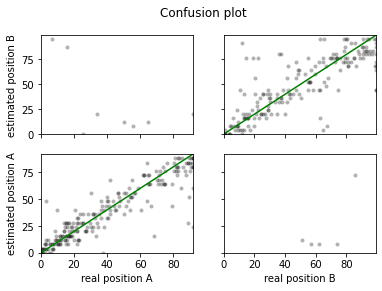

In [ ]:
# plot confusion matrix (real vs estimated position)
fig, ax = plt.subplots(len(arms), len(arms), sharex="col", sharey="row")
fig.suptitle("Confusion plot")

for r, e in zip(reals, estimates):
    for k1 in range(len(arms)):
        for k2 in range(len(arms)):
            b = np.logical_and(r[:, 0] == k1, e[:, 0] == k2)
            ax[len(arms) - 1 - k2, k1].plot(
                r[b, 1], e[b, 1], "ko", alpha=0.3, markersize=4, markeredgecolor="none"
            )

for idx, k in enumerate(arms):
    ax[len(arms) - 1 - idx, 0].set_ylabel("estimated position " + k)
    ax[-1, idx].set_xlabel("real position " + k)
    arm_length = arms[k]["track"].pathlength
    ax[len(arms) - 1 - idx, idx].plot([0, arm_length], [0, arm_length], "g")
    ax[len(arms) - 1 - idx, idx].set_xlim(0, arm_length)
    ax[len(arms) - 1 - idx, idx].set_ylim(0, arm_length)

# compute median error
median_error = np.median(np.concatenate(errors))
median_error_by_arm = {
    k: np.median(np.concatenate(errors)[np.concatenate(reals, axis=0)[:, 0] == idx])
    for idx, k in enumerate(arms)
}

# compute arm decoding performance
correct = 100 * np.mean(
    np.concatenate(reals, axis=0)[:, 0] == np.concatenate(estimates, axis=0)[:, 0]
)
correct_by_arm = {
    k: 100
    * np.sum(
        np.logical_and(
            np.concatenate(reals, axis=0)[:, 0] == 0,
            np.concatenate(estimates, axis=0)[:, 0] == 0,
        )
    )
    / np.sum(np.concatenate(reals, axis=0)[:, 0] == 0)
    for idx, k in enumerate(arms)
}

overall median error is 6.1cm
median error per maze arm is A: 5.0cm, B: 7.6cm
overall % correct maze arm is 97%
% correct per maze arm is A: 96%, B: 96%


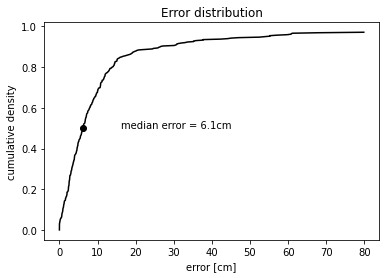

In [ ]:
# plot error distribution
def ecdf(x):
    return np.sort(x), np.arange(1, len(x) + 1, dtype=float) / len(x)


x, y = ecdf(np.concatenate(errors))

# note that the cumulative density function does not reach 1
# which is due to setting the error to Inf when the incorrect
# arm is estimated

plt.plot(x, y, "k")
plt.ylabel("cumulative density")
plt.xlabel("error [cm]")
plt.title("Error distribution")
plt.plot(median_error, 0.5, "ko")
plt.text(median_error + 10, 0.5, "median error = {0:0.1f}cm".format(median_error))

# print summary statistic
print("overall median error is {0:0.1f}cm".format(median_error))
print(
    "median error per maze arm is "
    + ", ".join(
        ["{0}: {1:0.1f}cm".format(k, v) for k, v in median_error_by_arm.items()]
    )
)

print("overall % correct maze arm is {0:0.0f}%".format(correct))
print(
    "% correct per maze arm is "
    + ", ".join(["{0}: {1:0.0f}%".format(k, v) for k, v in correct_by_arm.items()])
)